In [3]:
import os
import sys
sys.path.append('..')
import pandas as pd
import argparse
import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from dataloader import get_training_dataloader, get_test_dataloader
from conf import settings
from utils import get_network, WarmUpLR, most_recent_folder, most_recent_weights, last_epoch, best_acc_weights
from functions import train, eval_training

ModuleNotFoundError: No module named 'augmentation.mixup'

In [ ]:
# Settings
parser = argparse.ArgumentParser()
parser.add_argument('-resume', action='store_true', default=False, help='resume training')
parser.add_argument('--device', type=str, default='cpu', help='the device: cpu or gpu')
parser.add_argument('--lr', type=float, default=0.1, help='initial learning rate')
parser.add_argument('--optimizer', type=str, default='sgd', help='optimizer')
parser.add_argument('--criterion', type=str, default='CrossEntropyLoss', help='criterion')
parser.add_argument('--batch-size', type=int, default=128, help='batch size')
# 选择网络，默认使用resnet18
parser.add_argument('--net', type=str, default="resnet18", help='the models name')
parser.add_argument('--data', type=str, default='cifar100', help="the dataset cifar100")
parser.add_argument('--argumentation', type=str, default="cutout", help="the type of argumentation: mixup, cutout, "
                                                                    "cutmix")
# warm up
parser.add_argument('--warmup-num', type=int, default=0, help="the epoch number of warmup, 0 means no warmup")
parser.add_argument('--argumentation-param', type=float, default=8,
                    help="the parameter of the argumentation, patch length for cutout and alpha for mixup and "
                         "cutmix")

# args = parser.parse_args()
# jupyter
args =parser.parse_known_args()[0]

# TODO: load model
# utils中的函数，根据args中的net参数选择model中对应的网络
net = get_network(args)

# TODO: load data

if args.data == "cifar100":
    mean = settings.CIFAR100_TRAIN_MEAN
    std = settings.CIFAR100_TRAIN_STD
else:
    raise ValueError("the data should be cifar100, but {} is given.".format(args.data))

train_loader = get_training_dataloader(
    mean=mean,
    std=std,
    batch_size=args.batch_size,
    data=args.data,
    argumentation=args.argumentation,
    # 这里只处理了cutout情形
    cutout_length=args.argumentation_param
)

test_loader = get_test_dataloader(
    mean=mean,
    std=std,
    batch_size=args.batch_size,
    data=args.data,
)

# TODO: construct loss function and optimizer
if args.criterion == "CrossEntropyLoss":
    loss_function = nn.CrossEntropyLoss()
    # 只能选择交叉熵作为损失函数
if args.optimizer == "sgd":
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
elif args.optimizer == "adam":
    optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=5e-4)
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=settings.MILESTONES,
                                                 gamma=0.5)  # learning rate decay
# train_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))

# TODO: whether to warmup or not
if args.warmup_num:
    iter_per_epoch = len(train_loader)
    warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * args.warmup_num)
    warmup_dict = {"warmup_scheduler": warmup_scheduler, "warmup_num": args.warmup_num}
else:
    warmup_dict = None

# TODO: whether to train from checkpoint
if args.resume:
    recent_folder = most_recent_folder(os.path.join(settings.CHECKPOINT_PATH, args.net),
                                       fmt=settings.DATE_FORMAT)
    if not recent_folder:
        raise Exception('no recent folder were found')

    checkpoint_path = os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder)

else:
    checkpoint_path = os.path.join(settings.CHECKPOINT_PATH, args.net,
                                   settings.TIME_NOW + "_" + args.net + "_" +
                                   str(args.argumentation) + "_" + str(args.argumentation_param) + "_" + args.data)

# TODO: settings
# use tensorboard
if not os.path.exists(settings.LOG_DIR):
    os.mkdir(settings.LOG_DIR)

writer = SummaryWriter(log_dir=os.path.join(
    settings.LOG_DIR, args.net,
    settings.TIME_NOW + "_" + args.net + "_" +
    str(args.argumentation) + "_" + str(args.argumentation_param) + "_" + args.data))
input_tensor = torch.Tensor(1, 3, 32, 32)
if args.device != "cpu":
    input_tensor = input_tensor.to(args.device)
writer.add_graph(net, input_tensor)

# create checkpoint folder to save models
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint_path = os.path.join(checkpoint_path, '{net}-{epoch}-{type}.pth')

# TODO: train

best_acc = 0.0
if args.resume:
    best_weights = best_acc_weights(os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder))
    # best_weights返回路径中存储的最佳best weight
    if best_weights:
        weights_path = os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder, best_weights)
        print('found best acc weights file:{}'.format(weights_path))
        print('load best training file to test acc...')
        net.load_state_dict(torch.load(weights_path))
        best_acc = eval_training(
            model=net,
            data_loader=test_loader,
            device=args.device,
            loss_function=loss_function,
            epoch=0,
            writer=None)
        print('best acc is {:0.2f}'.format(best_acc))

    recent_weights_file = most_recent_weights(os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder))
    if not recent_weights_file:
        raise Exception('no recent weights file were found')
    weights_path = os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder, recent_weights_file)
    print('loading weights file {} to resume training.....'.format(weights_path))
    net.load_state_dict(torch.load(weights_path))

    resume_epoch = last_epoch(os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder))

old_path = None
acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, settings.EPOCH + 1):
    if epoch > args.warmup_num:
        train_scheduler.step(epoch)

    if args.resume:
        if epoch <= resume_epoch:
            continue

    train_loss = train(
        model=net,
        data_loader=train_loader,
        device=args.device,
        optimizer=optimizer,
        loss_function=loss_function,
        epoch=epoch,
        batch_size=args.batch_size,
        warmup_dict=warmup_dict,
        writer=writer,
        argumentation=args.argumentation,
        alpha=args.argumentation_param
    )
    acc, test_loss = eval_training(
        model=net,
        data_loader=test_loader,
        device=args.device,
        loss_function=loss_function,
        epoch=epoch,
        writer=writer
    )
    acc_list.append(acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    

    # start to save best performance models after learning rate decay to 0.01
    if epoch > settings.MILESTONES[1] and best_acc < acc:
        weights_path = checkpoint_path.format(net=args.net, epoch=epoch, type='best')
        print('saving weights file to {}'.format(weights_path))
        torch.save(net.state_dict(), weights_path)
        # delete old best model
        if old_path is not None:
            os.remove(old_path)
        # update
        old_path = weights_path
        best_acc = acc
        continue

    if not epoch % settings.SAVE_EPOCH:
        weights_path = checkpoint_path.format(net=args.net, epoch=epoch, type='regular')
        print('saving weights file to {}'.format(weights_path))
        torch.save(net.state_dict(), weights_path)

writer.close()

df_loss_acc = pd.DataFrame({'test_acc':acc_list,'test_loss':test_loss_list,'train_loss':train_loss_list})
df_loss_acc.to_csv("LossAcc_cutout_8_lrgm05.csv",index=False)

Files already downloaded and verified
Files already downloaded and verified


/home/lizhe/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/lizhe/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your

Training Epoch: 1 [128/50000]	Loss: 4.7085	LR: 0.100000
Training Epoch: 1 [256/50000]	Loss: 4.6967	LR: 0.100000
Training Epoch: 1 [384/50000]	Loss: 4.6913	LR: 0.100000
Training Epoch: 1 [512/50000]	Loss: 4.7383	LR: 0.100000
Training Epoch: 1 [640/50000]	Loss: 4.9857	LR: 0.100000
Training Epoch: 1 [768/50000]	Loss: 4.9962	LR: 0.100000
Training Epoch: 1 [896/50000]	Loss: 4.8092	LR: 0.100000
Training Epoch: 1 [1024/50000]	Loss: 5.0228	LR: 0.100000
Training Epoch: 1 [1152/50000]	Loss: 4.9969	LR: 0.100000
Training Epoch: 1 [1280/50000]	Loss: 5.0002	LR: 0.100000
Training Epoch: 1 [1408/50000]	Loss: 5.0947	LR: 0.100000
Training Epoch: 1 [1536/50000]	Loss: 5.2664	LR: 0.100000
Training Epoch: 1 [1664/50000]	Loss: 5.0734	LR: 0.100000
Training Epoch: 1 [1792/50000]	Loss: 4.9109	LR: 0.100000
Training Epoch: 1 [1920/50000]	Loss: 4.8457	LR: 0.100000
Training Epoch: 1 [2048/50000]	Loss: 4.7324	LR: 0.100000
Training Epoch: 1 [2176/50000]	Loss: 4.8870	LR: 0.100000
Training Epoch: 1 [2304/50000]	Loss: 4

In [2]:
base = pd.read_csv("LossAcc.csv")
cutmix = pd.read_csv("LossAcc_cutmix_0p5.csv")
cutout = pd.read_csv("LossAcc_cutout_8.csv") 
mixup = pd.read_csv("LossAcc_mixup_0p5.csv")

In [3]:
base['test_acc'] = list(map(lambda x: float(x.split("(")[1].split(")")[0]), base['test_acc']))
cutmix['test_acc'] = list(map(lambda x: float(x.split("(")[1].split(")")[0]), cutmix['test_acc']))
cutout['test_acc'] = list(map(lambda x: float(x.split("(")[1].split(")")[0]), cutout['test_acc']))
mixup['test_acc'] = list(map(lambda x: float(x.split("(")[1].split(")")[0]), mixup['test_acc']))

In [4]:
base['train_loss'] = list(map(lambda x: x/50000, base['train_loss']))
cutmix['train_loss'] = list(map(lambda x: x/50000, cutmix['train_loss']))
cutout['train_loss'] = list(map(lambda x: x/50000, cutout['train_loss']))
mixup['train_loss'] = list(map(lambda x: x/50000, mixup['train_loss']))

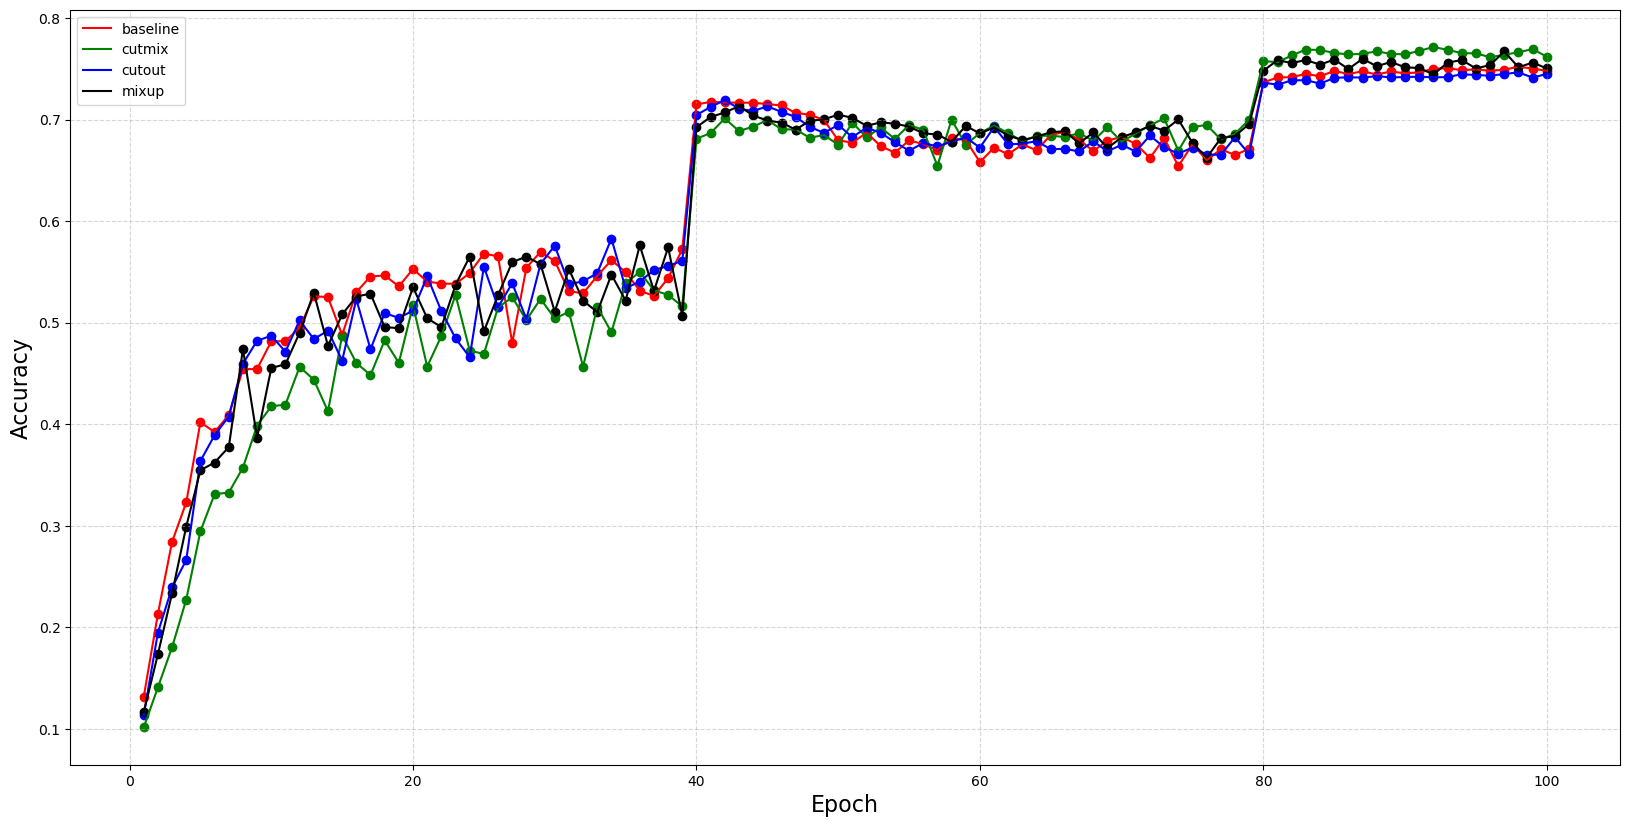

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10), dpi=100)
epoch = range(1,101)
baseline = base['test_acc']
cutmix = cutmix['test_acc']
cutout = cutout['test_acc']
mixup = mixup['test_acc']
plt.plot(epoch, baseline, c='red', label="baseline")
plt.plot(epoch, cutmix, c='green', label="cutmix")
plt.plot(epoch, cutout, c='blue', label="cutout")
plt.plot(epoch, mixup, c='black', label="mixup")
plt.scatter(epoch, baseline, c='red')
plt.scatter(epoch, cutmix, c='green')
plt.scatter(epoch, cutout, c='blue')
plt.scatter(epoch, mixup, c='black')
plt.legend(loc='best')
# plt.yticks(range(0, 50, 5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Epoch", fontdict={'size': 16})
plt.ylabel("Accuracy", fontdict={'size': 16})
plt.show()
